# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

# Tensorflow backend initialization

In [2]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Function definitions

In [3]:
def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig


def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def resample_df(df, sample_rate, combine_all_dwellings=False):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Input df may also be multiple dwelling dfs combined.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    
    Combine all dwellings: resamples the df and ignores the fact that there are unique dwellings.
    
    TODO: add std to ePower, gasPower when combine_all_dwellings=False
    """
    df = df.copy()
    
    def resample_dwelling(df, sample_rate, dwelling_id):
        df = df.resample(sample_rate).mean() # resample to rest by mean
        df['dwelling'] = dwelling_id
        return df
        
                      
    resampled_dwellings = []
    
    if combine_all_dwellings: # Ignore dwelling_ids
        df = df.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Drop columns because they are meaningless when ignoring dwelling ids
        resampled_df = resample_dwelling(df, sample_rate, 'All dwellings')
        resampled_dwellings.append(resampled_df)
    else:
        dwellings = df['dwelling'].unique() # Get dwelling ids
        for dwelling_id in tqdm(dwellings):
            dwelling_df = df[df['dwelling'] == dwelling_id] # Get the data from only that dwelling_id
            resampled_dwelling = resample_dwelling(dwelling_df, sample_rate, dwelling_id)
            resampled_dwellings.append(resampled_dwelling)
    
    resampled_df = pd.concat(resampled_dwellings)
    
    return resampled_df

# Preparing dataframe for preprocessing

In [4]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//P01S01W8655_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'D') # For some reason this makes df equal h, so it changes the df variable being read in at the start...
#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['hour'] = df.index.hour #create column containing the hour
#df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

#df = df.iloc[-7*5:]

100%|██████████| 1/1 [00:00<00:00, 164.22it/s]

CPU times: user 28.8 ms, sys: 6.12 ms, total: 34.9 ms
Wall time: 32.4 ms


In [5]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-24,780.522364,0.0,736.983000,0.0,450.653377,0.0,1592.778182,267.907575,151.272727,4.926667,...,0.350000,0.220361,10.819697,11.121212,6.662121,75.712122,29368.333455,29.696970,0.201372,P01S01W8655
2017-04-25,784.964250,0.0,738.217500,0.0,365.682568,0.0,1595.581708,285.680485,47.416667,5.478194,...,0.080208,4.004910,6.503472,6.373403,1.977500,72.906250,36118.680500,23.550000,0.150121,P01S01W8655
2017-04-26,792.118045,0.0,739.742318,0.0,376.575828,0.0,1601.333091,270.914473,42.545455,3.074758,...,0.112348,3.856208,6.132197,5.827121,2.092727,76.340910,34583.575909,12.346970,0.375732,P01S01W8655
2017-04-27,796.967000,0.0,744.674917,0.0,411.699121,0.0,1608.707583,233.521111,17.708333,2.968375,...,0.023264,2.682295,6.181319,5.922500,2.129722,76.137500,36665.555917,11.267361,0.213999,P01S01W8655
2017-04-28,800.575875,0.0,751.724250,0.0,511.259890,0.0,1614.828083,266.770347,58.366667,2.997917,...,0.156111,2.737647,7.958750,7.910486,4.364167,78.612500,33648.791625,18.394445,0.251663,P01S01W8655


## Get a proper hourly dataframe

Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

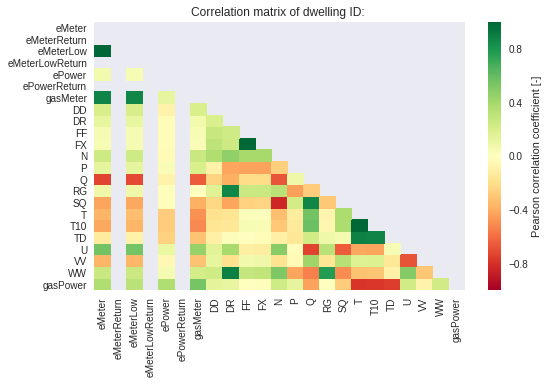

In [6]:
fig = create_corr_matrix(df, '', False)

## Select data we want

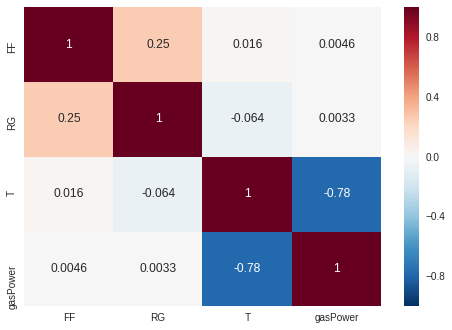

In [7]:
data = df
data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

sns.heatmap(data.corr(), annot=True)

# EDA

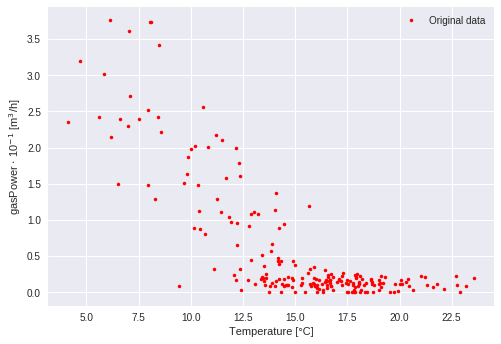

In [8]:
plt.plot(data['T'], data['gasPower'], '.', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()

In [9]:
#sns.pairplot(data)

# Preprocessing

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [11]:
def create_timeseries_history(df, columns_to_lookback, n_lookback, dropnan=True):
    """
    df, pandas dataframe
    columns_to_lookback, the columns to gather historical data from
    n_lookback, amount of samples to look back for. 
    
    Example:
    df = dwelling_df['FF']
    columns_to_lookback = df.columns
    n_lookback = 3
    
    
    Output columns:
    FF, FF (t-1), FF (t-2), FF (t-3)
    
    Where FF (t-3) contains the FF value of 3 samples (indices) back.
    """
    n_lookback += 1 # +1 because iteration starts at 0.
    df = df.copy()
    
    for column in columns_to_lookback:
        if column == 'datetime':
            pass
        else:
            for dt in range(n_lookback):
                if dt == 0:
                    pass
                else: 
                    df[column+'(t-%s)' % dt ] = df[column].shift(dt)
    if dropnan:
        df = df.dropna()
        
    return df

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    columns = data.columns
    
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
seed = 42

# Create history data
#data = create_timeseries_history(data, columns_to_lookback=data.columns, n_lookback=1, dropnan=True)
data = series_to_supervised(data, 7, 1) 
print('Data columns: %s' % list(data.columns))

Data columns: ['FF(t-7)', 'RG(t-7)', 'T(t-7)', 'gasPower(t-7)', 'FF(t-6)', 'RG(t-6)', 'T(t-6)', 'gasPower(t-6)', 'FF(t-5)', 'RG(t-5)', 'T(t-5)', 'gasPower(t-5)', 'FF(t-4)', 'RG(t-4)', 'T(t-4)', 'gasPower(t-4)', 'FF(t-3)', 'RG(t-3)', 'T(t-3)', 'gasPower(t-3)', 'FF(t-2)', 'RG(t-2)', 'T(t-2)', 'gasPower(t-2)', 'FF(t-1)', 'RG(t-1)', 'T(t-1)', 'gasPower(t-1)', 'FF(t)', 'RG(t)', 'T(t)', 'gasPower(t)']


In [13]:
type(data)

pandas.core.frame.DataFrame

In [14]:
X = data.drop(['gasPower(t)'], axis=1)
print('X columns: %s' % list(X.columns))

#sns.heatmap(X.corr(), annot=True)

y = data[['gasPower(t)']]

# Get it in the right shape
X = np.array(X).reshape(-1, len(X.columns))
y = np.array(y).reshape(-1, len(y.columns))

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X columns: ['FF(t-7)', 'RG(t-7)', 'T(t-7)', 'gasPower(t-7)', 'FF(t-6)', 'RG(t-6)', 'T(t-6)', 'gasPower(t-6)', 'FF(t-5)', 'RG(t-5)', 'T(t-5)', 'gasPower(t-5)', 'FF(t-4)', 'RG(t-4)', 'T(t-4)', 'gasPower(t-4)', 'FF(t-3)', 'RG(t-3)', 'T(t-3)', 'gasPower(t-3)', 'FF(t-2)', 'RG(t-2)', 'T(t-2)', 'gasPower(t-2)', 'FF(t-1)', 'RG(t-1)', 'T(t-1)', 'gasPower(t-1)', 'FF(t)', 'RG(t)', 'T(t)']
X shape:  (201, 31)
y shape:  (201, 1)


# Reshape and scale the data

In [15]:
def scale_reshape(X_train, X_test, y_train, y_test):
    """
    Input: X and y as pandas dataframes.
    Scales and reshapes X and y. 
    Output: X and y as numpy ndarrays.
    """
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.copy()
    y_test = y_test.copy()
    
    # Scale the data
    scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
    #scalery = StandardScaler(with_mean=True, with_std=True).fit(y_train)

    # Normalize X arrrays
    X_train = scalerX.transform(X_train)
    X_test = scalerX.transform(X_test)

    # Get test data in the correct shape and format
    y_train = np.array(y_train).reshape(-1,1) #reshape if y_train is not scaled, transforming should not be needed
    y_test = np.array(y_test).reshape(-1,1)
    
    return X_train, X_test, y_train, y_test


def to_LSTM_shape(array):
    """
    Reshapes a 2D array to 3D for LSTM usage (samples, timesteps, feautures). 
    For example, reshapes (104, 8) to (104, 1, 8)#
    
    """
    array = array.copy()
    if len(array.shape) == 3:
        return array
    
    array = array.reshape(array.shape[0], 1, array.shape[1])

    return array

# Predict gasPower with most other variables

# Create the model

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU


def abs_percentage_error(y_true, y_pred):
    import keras.backend as K
    """
    Returns the absolute value of the difference between y_true and y_pred (in percentage).
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100


def make_model():
    model = Sequential()
    
    model.add(LSTM(7, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer='TruncatedNormal', return_sequences=True))
    model.add(LeakyReLU())
    
    for i in range(14):
        model.add(LSTM(7, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(LeakyReLU())
    
    #model.add(Dropout(0.5))
    
    #model.add(Flatten())
    
    N = 256 #45
    
    #for i in range(4):
    #    model.add(Dense(N-i*4, kernel_initializer='normal'))
    #    model.add(Activation('relu'))
    #    model.add(Dropout(0.5, seed=seed))
    
    model.add(Flatten())
    
    model.add(Dense(1, kernel_initializer='TruncatedNormal'))
    model.add(Activation('linear'))
    return model


def compile_fit(model):
    # Compile and fit
    #model = multi_gpu_model(model, gpus=num_gpu)

    
    lr = 0.01
    epochs = 500
    decay_rate = 0.1
    
    sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

    # compiling the sequential model
    #multi_model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mse', metrics=['mse', abs_percentage_error], optimizer=sgd)

    early_stopping_monitor = EarlyStopping(patience=1)

    #tensorboard = TensorBoard(log_dir="/home/16011015/notebooks/logs/{}".format(time()))

    # training the model and saving metrics in history
    model.fit(X_train, y_train, batch_size=int(len(X_train)), 
                    epochs=epochs, verbose=2, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping_monitor, PlotLossesKeras()])
    
    
    
    return model

# Compile & fit model

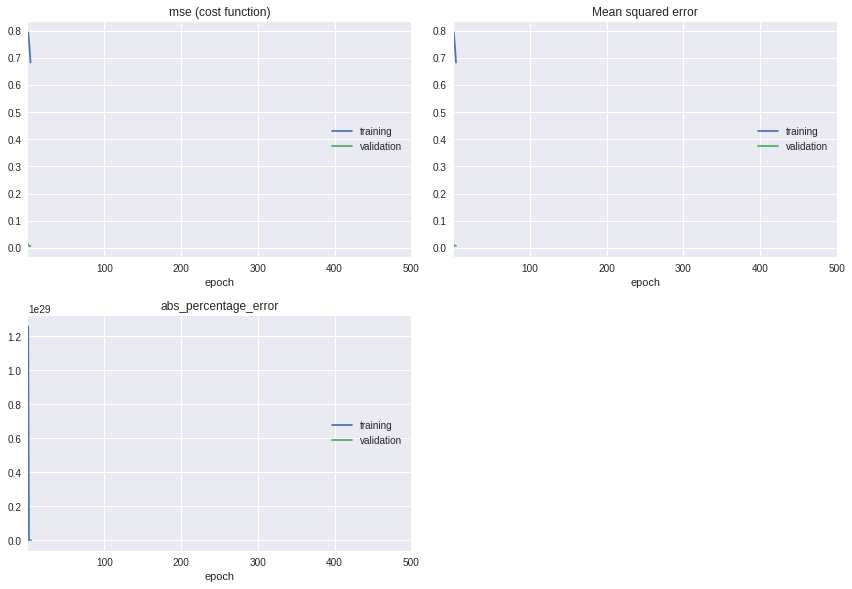

 - 0s - loss: 0.6830 - mean_squared_error: 0.6830 - abs_percentage_error: 652.5175 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_abs_percentage_error: 51.5569
7/7 [==============================] - 0s 1ms/step
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] 	 Test: [26 27 28 29 30 31 32]
X shape:  (26, 1, 31)
Train on 26 samples, validate on 7 samples
Epoch 1/500


In [ ]:
%%time


scores = []
y_tests = []
y_preds = []
test_indices = []

n = 26
for train_index, test_index in TimeSeriesSplit(n_splits=n, max_train_size=None).split(X):
    # Train on one month, try to predict 1 week ahead, n_splits=26, max_train_size=4*7
    print("Train: %s \t Test: %s" % (train_index, test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] # could manually assign a max size to this
    
    #Scale reshape
    X_train, X_test, y_train, y_test = scale_reshape(X_train, X_test, y_train, y_test)
    
    X_train = to_LSTM_shape(X_train)
    X_test = to_LSTM_shape(X_test)
    
    print('X shape: ', X_train.shape)
    # Create the keras model
    model = make_model()
    
    # Compile and fit the model
    model = compile_fit(model)
    
    scores.append(model.evaluate(X_test, y_test))
    y_tests.append(y_test)
    y_preds.append(model.predict(X_test))
    test_indices.append(test_index)



In [ ]:
# Create a dataframe containing the model scores
df_scores = pd.DataFrame(scores, columns=['loss', 'mse', 'abs percentage error'])
df_scores

In [ ]:
y_t = np.vstack(y_tests) # List of ndarrays to one ndarray
y_p = np.vstack(y_preds)

# Get the x values for y predictions
start = np.concatenate(test_indices)[0] # start y pred index
stop = np.concatenate(test_indices)[-1] # stop y pred index
x = data.index[start:stop+1] # series of dates from start to stop+1

plt.figure(figsize=(20,10))
plt.plot(x, y_t, '.-', color='r')
plt.plot(x, y_p, '.-', color='b')

plt.plot(data.index[:start], data['gasPower(t)'][:start], '.-', color='seagreen', label='Real values') # shows training data
plt.plot(x, y_t, '.-', color='firebrick', label='Real values', alpha=1)
plt.plot(x, y_p, '.-', color='royalblue', label='Predicted values', alpha=1)

plt.xlabel('datetime [-]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.xticks(rotation=45)
plt.legend()


mse_mean = df_scores['mse'].mean()
mse_std = df_scores['mse'].std()
percentage_mean = df_scores['abs percentage error'].mean()
percentage_std = df_scores['abs percentage error'].std()

plt.title('Deep neural network regression results with gasPower as the target \n \
          MSE$_{mean}$ = %.2f \t MSE$_{std}$ = %.2f \n \
          Error in percentage:    mean = %.2f [%%]    std = %.2f [%%]' % (mse_mean, mse_std, percentage_mean, percentage_std), fontsize = 14)
plt.tight_layout()

#plt.savefig('figures/8655 result.png', dpi=1000)
print('FINISHED')

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)